In [2]:
import sys
import os
import pandas as pd

from sklearn import set_config
set_config(transform_output = "pandas")

# Custom utils
PROJECT_ROOT = '../'
MODEL_PATH = os.path.join(PROJECT_ROOT,'models','RF__features_ANN_RF')
sys.path.append(PROJECT_ROOT)
from scripts.data_utils import load_downsampled_df, load_full_df, get_train_validation_df, test_train_validation_split
from scripts.Ensemble_Functions import load_constituent_models, load_constituent_pipelines, ModelPredictor
from models.ANN.functions import ANN_predict_proba
from models.RF.functions import RF_predict_proba
from models.RF__features_ANN_RF.functions import get_predictions_pipeline, create_classifier_pipeline

In [7]:
# Load and split data

main_df = load_downsampled_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
X_train, X_test, X_validation, y_train, y_test, y_validation = test_train_validation_split(validation_df,test_train_df)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)

In [4]:
## Load models ##

# Define model and preprocessing pipeline paths
ANN_model_path = os.path.join(PROJECT_ROOT,'models','ANN','ANN.h5')
ANN_pipe_path = os.path.join(PROJECT_ROOT,'models','ANN','ANN_preprocess_pipeline.joblib')
RF_model_path = os.path.join(PROJECT_ROOT,'models','RF','RF_model.joblib')
RF_pipe_path = os.path.join(PROJECT_ROOT,'models','RF','RF_preprocess_pipeline.joblib')

# Load models and pipelines
models = load_constituent_models(ANN_model_path,RF_model_path)
ANN_model = models[ANN_model_path]
RF_model = models[RF_model_path]

pipelines = load_constituent_pipelines(ANN_pipe_path,RF_pipe_path)
ANN_pipeline = pipelines[ANN_pipe_path]
RF_pipeline = pipelines[RF_pipe_path]

# Freeze the ANN model
for layer in ANN_model.layers:
    layer.trainable = False

In [5]:
## Create model predictors ##

ann_predictor = ModelPredictor(ANN_model, ANN_pipeline, ANN_predict_proba, 'ANN')
rf_predictor = ModelPredictor(RF_model, RF_pipeline, RF_predict_proba, 'RF')

In [8]:
## Create the predictions features pipeline ##

add_predictions_pipeline = get_predictions_pipeline(ann_predictor,rf_predictor)

In [15]:
## Create and fit the remainder of the model ##

ensemble_pipeline = create_classifier_pipeline()

X_train_with_predictions = add_predictions_pipeline.transform(X_train)
ensemble_pipeline.fit(X_train_with_predictions,y_train)

Pipeline(steps=[('day_of_year',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  FunctionTransformer(func=<function extract_day_of_year at 0x000001C5E1E82B00>),
                                                  ['date'])],
                                   verbose_feature_names_out=False)),
                ('feature_union',
                 FeatureUnion(transformer_list=[('numeric',
                                                 ColumnTransformer(transformers=[('scale_transformer',
                                                                                  StandardScaler(),
                                                                                  ['fir...
                                                                                  OneHotEncoder(sparse_output=False),
                                                                                  ['type_of_high_vegetation'])],
                                                                   verbose_feature_names_out=False)),
                                                ('pass',
                                                 ColumnTransformer(transformers=[('Pass_transformer',
                                                                                  'passthrough',
                                                                                  ['leaf_area_index_high_vegetation',
                                                                                   'ANN_Prediction',
                                                                                   'RF_Prediction',
                                                                                   'slope_of_sub_gridscale_orography'])],
                                                                   verbose_feature_names_out=False))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
## Save the classifier pipeline
from joblib import dump

dump(ensemble_pipeline,os.path.join(MODEL_PATH,'RF__features_ANN_RF__classifier.joblib'))

**Evaluation**

In [20]:
from scripts.Visualization_functions import generate_visualizations, print_metrics, plot_roc_curve

In [13]:
# Get the validation dataset
main_df = load_full_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
_, X_test, X_validation, _, y_test, y_validation = test_train_validation_split(validation_df,test_train_df)

X_test.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)

In [3]:
# Load the model if needed
from joblib import load

clf = load(os.path.join(MODEL_PATH,'RF__features_ANN_RF__classifier.joblib'))

In [17]:
# Get Predictions
X_val_with_predictions = add_predictions_pipeline.transform(X_validation)
y_val_pred_proba = clf.predict_proba(X_val_with_predictions)[:,1]

5637/5637 ━━━━━━━━━━━━━━━━━━━━ 3s 449us/step


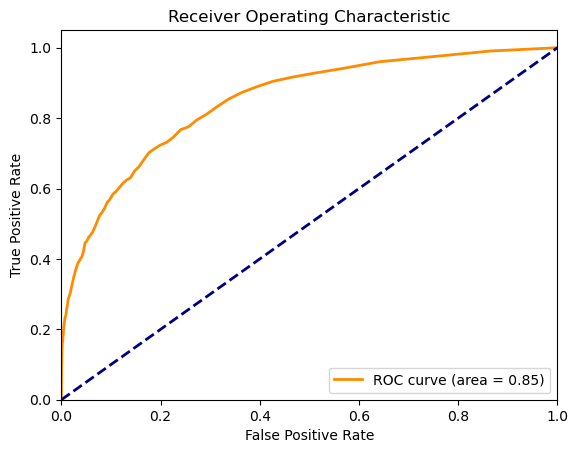

In [21]:
plot_roc_curve(y_validation, y_val_pred_proba)

In [22]:
thresh = 0.8
y_val_pred = (y_val_pred_proba > thresh).astype(int)
generate_visualizations(X_validation,y_val_pred,y_validation,main_df,os.path.join(MODEL_PATH,"RF_stack_Visuals"))

In [23]:
thresh = 0.8
y_val_pred = (y_val_pred_proba > thresh).astype(int)
print_metrics(y_validation,y_val_pred)

Validation set accuracy: 0.9948273281181564
f1 score:  0.20051413881748073
Precision: 0.2819277108433735
Recall: 0.15558510638297873


In [24]:
# Save validation probabilities
import numpy as np

np.save(os.path.join(MODEL_PATH,'RF_stack_y_val_proba.npy'),y_val_pred_proba)

**Hyperparameter Tuning**

In [ ]:
X_train_predictions = X_train_with_predictions

In [37]:
## Initial Grid Search ##
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'classifier__n_estimators': [75,200,500],  # Number of trees in the forest
    'classifier__max_depth': [8,10,60],
    #'classifier__min_samples_leaf': [2,5,40],
    #'classifier__min_samples_split': [5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'classifier__max_depth': 60, 'classifier__n_estimators': 500}
F1 Score: 80.32%


In [38]:
## Secondary Grid Search ##
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'classifier__n_estimators': [400,500,800],  # Number of trees in the forest
    'classifier__max_depth': [60,80,None],
    'classifier__min_samples_leaf': [2,10,50],
    #'classifier__min_samples_split': [5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Fitting 5 folds for each of 27 candidates, totalling 135 fits
#Best parameters: {'classifier__max_depth': 60, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 800}
#F1 Score: 80.17%

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'classifier__max_depth': 60, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 800}
F1 Score: 80.17%


In [39]:
## Tertiary Grid Search ##
param_grid = {
    'classifier__n_estimators': [700,800,1200],
    'classifier__max_depth': [55,60,65],
    'classifier__min_samples_leaf': [None,2,10],
    #'classifier__min_samples_split': [5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=8,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 1200}
#F1 Score: 80.21%

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._fina

Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 1200}
F1 Score: 80.21%


In [40]:
## 4th Grid Search ##
param_grid = {
    'classifier__n_estimators': [1200],
    'classifier__max_depth': [50,55],
    'classifier__min_samples_leaf': [1,2],
    'classifier__min_samples_split': [2,5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=8,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Fitting 5 folds for each of 12 candidates, totalling 60 fits
#Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1200}
#F1 Score: 80.28%

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1200}
F1 Score: 80.28%


In [44]:
## 5th Grid Search ##
param_grid = {
    'classifier__n_estimators': [1200, 1500],
    'classifier__max_depth': [55,60],
    'classifier__min_samples_leaf': [1,2],
    #'classifier__min_samples_split': [2] #default 2
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Fitting 5 folds for each of 8 candidates, totalling 40 fits
#Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 1500}
#F1 Score: 80.00%

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'classifier__max_depth': 55, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 1500}
F1 Score: 80.00%
